In [1]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
import torch
from tqdm import tqdm
from statistics import mean
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.nn.functional import threshold, normalize
from torchvision.utils import save_image
import src.utils as utils
from src.dataloader import DatasetSegmentation, collate_fn
from src.processor import Samprocessor
from src.segment_anything import build_sam_vit_b, SamPredictor
from src.lora import LoRA_sam
import matplotlib.pyplot as plt
import yaml
import torch.nn.functional as F

In [3]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

import cv2
import numpy as np

def polygon_vertices(mask):
    '''
    Find contours in the binary image and return both external and internal polygons.

    mask: binary image to find contours in
    '''
    # Convert the image into 0 and 1 (background and foreground)
    #_, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours and hierarchy
    contours, hierarchy = cv2.findContours(mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract segmentations
    external_polygons = []
    internal_polygons = []
    if hierarchy is not None:
        hierarchy = hierarchy[0]  # Flatten the hierarchy array
        for i, contour in enumerate(contours):
            # Approximate contour to polygon
            if len(contour) < 3:
                continue

            contour = cv2.approxPolyDP(contour, 1, True)
            segmentation = contour.flatten().tolist()

            # Determine if the contour is external or internal
            if hierarchy[i][3] == -1:
                # External contour
                external_polygons.append(segmentation)
            else:
                # Internal contour
                internal_polygons.append(segmentation)

    return external_polygons, internal_polygons




def calculate_polygon_area(vertices):
    # Ensure the polygon is closed (first and last vertices are the same)
    if vertices[0] != vertices[-2] or vertices[1] != vertices[-1]:
        vertices.extend(vertices[:2])

    # Calculate the area using the shoelace formula
    area = 0
    n = len(vertices) // 2
    for i in range(n - 1):
        area += (vertices[2*i] * vertices[2*i+3] - vertices[2*i+1] * vertices[2*i+2])
    area += (vertices[2*n-2] * vertices[1] - vertices[2*n-1] * vertices[0])
    return abs(area) / 2

def create_pair(t):
  pair = list(zip(t[::2],t[1::2]))
  new_pair = []
  for i in pair:
    new_pair.append(list(i))
  return new_pair

def remove_small_polygons(mask, threshold):
    if not isinstance(mask,np.ndarray):
        print('Takes a numpy array as input with entries either 0 or 255.')
        return
    segmentation, inner_polygons = polygon_vertices(mask)[0], polygon_vertices(mask)[1]
      
    outer_polygons = [polygon for polygon in segmentation if calculate_polygon_area(polygon) > threshold]
    
    binary_mask = np.zeros(mask.shape, dtype=np.uint8)
    for i in outer_polygons:
      pair = create_pair(i)
      polygon_points = np.array(pair, np.int32)
      cv2.fillPoly(binary_mask, [polygon_points], 255)
    
    for i in inner_polygons:
        pair = create_pair(i)
        polygon_points = np.array(pair, np.int32)
        cv2.fillPoly(binary_mask, [polygon_points], 0)

    
    return binary_mask/255



def apply_dense_crf(img, mask):
    """
    Applies DenseCRF to refine the segmentation mask.
    
    Args:
    - img (numpy array): The original image.
    - mask (numpy array): The initial segmentation mask.
    
    Returns:
    - refined_mask (numpy array): The refined segmentation mask.
    """
    # Convert image to numpy array if it's a tensor
    if isinstance(img, torch.Tensor):
        print('lala')
        img = img.numpy().transpose(1, 2, 0)

    # Get height and width of image
    h, w = img.shape[:2]

    # Ensure mask is a 2D array
    if mask.ndim == 3 and mask.shape[0] == 1:
        print('hi')
        mask = mask[0]
    elif mask.ndim == 3 and mask.shape[0] == 3:
        print('hello')
        # In case the mask is RGB
        mask = mask[0]

    # Ensure mask has the same height and width as the image
    assert mask.shape == (h, w), f"Mask shape {mask.shape} does not match image shape {(h, w)}"

    # Initialize DenseCRF
    d = dcrf.DenseCRF2D(w, h, 2)

    # Create unary potentials
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to range [0, 1]
    unary = np.stack([mask, 1 - mask], axis=0)  # Swapped to correctly represent foreground and background
    unary = unary.reshape((2, -1))  # Shape should be (num_classes, height*width)
    d.setUnaryEnergy(unary)

    # Create pairwise potentials
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=img, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

In [4]:
#!poetry run python train.py
# Load the config file
import matplotlib.image as mpimg

with open("/teamspace/studios/this_studio/Sam_LoRA/config.yaml", "r") as ymlfile:
   config_file = yaml.load(ymlfile, Loader=yaml.Loader)

# !!!!!Change the SAM CHECKPOINT to the path of the sam_lora model in config.yaml in Sam_LoRA folder!!!!!
# i.e.
# SAM:
#   CHECKPOINT: "../drive/MyDrive/sam_lora_model_train.pth"
#   RANK: 512

lora = torch.load(config_file["SAM"]["CHECKPOINT"])
#print(lora)
# Load SAM model
processor = Samprocessor(lora.sam)

#/content/drive/MyDrive/Model/inhouse_resized/samples/eastafrica_acactort_1_soilflag=0.jpg
'''
IMAGE_PATH = "../drive/MyDrive/Model/inhouse_resized/samples/eastafrica_acactort_1_soilflag=0.jpg"
image = mpimg.imread(IMAGE_PATH)
image = image.astype(np.uint8)
'''

predictor = SamPredictor(lora.sam)
# predictor.set_image(image)
# masks, scores, logits = predictor.predict(
#     point_coords=None,
#     point_labels=None,
#     box=None,
#     multimask_output=False,
# )

# print("SAM score for this mask is: " + str(scores[0]))

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_mask(masks[0], plt.gca())
# plt.axis('off')
# plt.show()


In [11]:
img_path = input('drop here')

drop here https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.10.27.12.35.13_8.441333333333334_-13.181376666666665_dcff3cf2-31f4-4c25-a0b1-c81c5e340497_IMG_20211027_110306_4766794252492051050.jpg


In [16]:
import os
sample_path = '/teamspace/studios/this_studio/Deeplab/india_sam_dino_annotations/samples'
india_samples = os.listdir(sample_path)
print(india_samples[0])
import random

india_psidguaj (guava)2020.10.21.17.01.50_22.043116120621562_86.3750886451453_109e2e3c-ef60-4710-8058-5d5884f25038_img_20201020_140157_2815177404586427848.jpg


In [7]:
import urllib.request
from io import BytesIO
import requests
from PIL import Image

In [5]:
 img_path = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/eastafrica_acactort_2020.08.27.17.13.48_d0c72c40-0fd8-4456-937c-a983343e43df_img_20200827_100055_357754425.jpg'

(480, 360, 3)
0.8436967


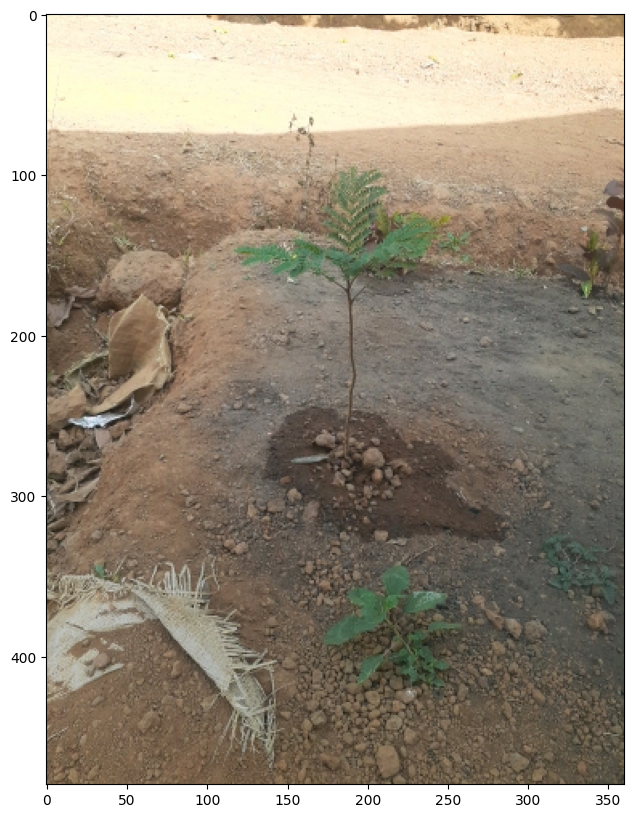

without crf


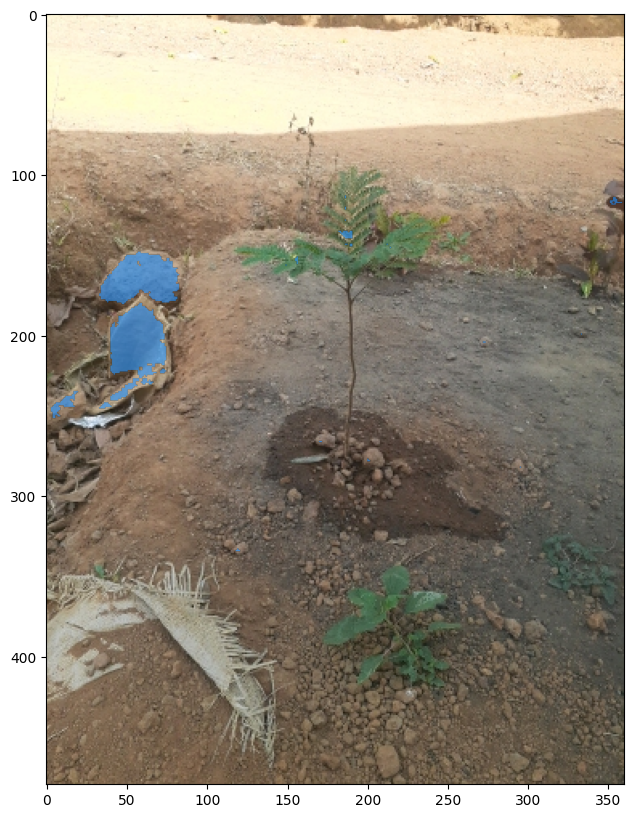

poly removed


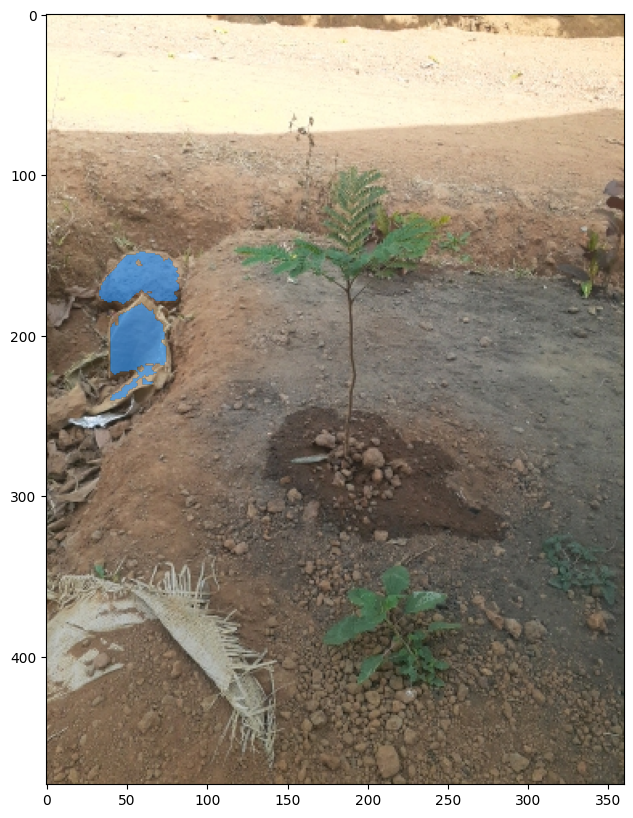

In [10]:
'''
r = random.randint(0, len(india_samples)-1)
img = cv2.imread(os.path.join(sample_path,india_samples[r]))
'''
response = requests.get(img_path)
img = Image.open(BytesIO(response.content))
img = np.array(img)
print(img.shape)
predictor.set_image(img)

input_box = np.array([0,0,img.shape[0],img.shape[1]])
masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )
print(scores[0])
refined_mask = apply_dense_crf(img, masks[0]*255)
changed = masks[0].astype(np.uint8)
poly_remove = (remove_small_polygons(changed,100))

plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(refined_mask, plt.gca())
plt.axis('on')
plt.show()

print('without crf')
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
plt.axis('on')
plt.show()

print('poly removed')
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(poly_remove, plt.gca())
plt.axis('on')
plt.show()